<a href="https://colab.research.google.com/github/Neilus03/Restb.ai_challenge-HackUPC2023/blob/Neil_branch/Copia_de_MLP_HackUPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import json
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import matplotlib.pyplot as plt

In [37]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
Big_Data = pd.read_pickle("/content/drive/MyDrive/HackUPC/HackUPC_Restb.ia/hackupc2023_restbai.pkl")

In [40]:
Big_Data = Big_Data.T

In [41]:
city2number         = {key: indice for indice, key in enumerate(Big_Data["city"].unique())}
neighborhood2number = {key: indice for indice, key in enumerate(Big_Data["neighborhood"].unique())}
region2number       = {key: indice for indice, key in enumerate(Big_Data["region"].unique())}

In [42]:
Big_Data['city']         = Big_Data['city'].map(city2number)
Big_Data['neighborhood'] = Big_Data['neighborhood'].map(neighborhood2number)
Big_Data['region']       = Big_Data['region'].map(region2number)

In [43]:
class DatasetFromPD(Dataset):
    def __init__(self, df):
        # Normalize features
        self.mean = df.mean()
        self.std = df.std()
        self.df_normalized = (df - df.mean()) / df.std()

        self.features = torch.tensor(self.df_normalized.drop(columns=['price']).values, dtype=torch.float32)
        self.target = torch.tensor(self.df_normalized['price'].values, dtype=torch.float)
    
    def get_mean(self):
        return self.mean

    def get_std(self):
        return self.std
    
    def desnormalize(self, predicted):
        return (predicted * torch.tensor(self.get_std()['price'], dtype=torch.float)) + torch.tensor(self.get_mean()['price'], dtype=torch.float)
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target  = self.target[idx]
        return feature, target


In [44]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [45]:
Big_Data = Big_Data.drop(columns = ["summary", "images", "image_data", "property_type", "num_images"])
Big_Data = Big_Data.fillna(0)

In [46]:
from sklearn.model_selection import train_test_split

# df is your DataFrame
train_data, valid_data = train_test_split(Big_Data, test_size=0.2, random_state=42)

train_dataset = DatasetFromPD(train_data)
val_dataset   = DatasetFromPD(valid_data)

In [47]:
# Create the Torch DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader   = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

In [48]:
# Your Code Here
import math
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_normal_(w, gain = math.sqrt(2)) 
        
        if "bias" in name:
            nn.init.ones_(w)

In [49]:
input_dim = 6
hidden_size = 512
output_dim = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MLP_model = MLP(input_dim, hidden_size, output_dim).to(device)
print(MLP_model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [50]:
learning_rate = 1e-3
lambda_l2 = 1e-8

optimizer = torch.optim.Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
criterion = torch.nn.MSELoss()

In [51]:
def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
      
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output.view(-1), target)
        loss.backward()
        optimizer.step()
        
        # print loss every N iterations
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))

        total_loss += loss.item() 

    return total_loss / len(loader.dataset)


In [52]:
@torch.no_grad()  # prevent this function from computing gradients see https://pytorch.org/docs/stable/generated/torch.no_grad.html
def validate(criterion, model, loader):

    val_loss = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, input_dim)  # reshaping the data
        output = model(data)
        loss = criterion(output.view(-1), target)
        val_loss += loss.item()

    val_loss /= len(loader.dataset)
    print('\nValidation set: Average loss: {:.4f}\n'.format(val_loss))

    return val_loss


Train Epoch: 0 [0/534940 (0%)]	Loss: 0.306645
Train Epoch: 0 [6400/534940 (1%)]	Loss: 2.411853
Train Epoch: 0 [12800/534940 (2%)]	Loss: 0.336390
Train Epoch: 0 [19200/534940 (4%)]	Loss: 0.693352
Train Epoch: 0 [25600/534940 (5%)]	Loss: 0.102338
Train Epoch: 0 [32000/534940 (6%)]	Loss: 0.126900
Train Epoch: 0 [38400/534940 (7%)]	Loss: 0.296603
Train Epoch: 0 [44800/534940 (8%)]	Loss: 0.276568
Train Epoch: 0 [51200/534940 (10%)]	Loss: 0.205324
Train Epoch: 0 [57600/534940 (11%)]	Loss: 0.143553
Train Epoch: 0 [64000/534940 (12%)]	Loss: 0.493087
Train Epoch: 0 [70400/534940 (13%)]	Loss: 0.094913
Train Epoch: 0 [76800/534940 (14%)]	Loss: 0.243047
Train Epoch: 0 [83200/534940 (16%)]	Loss: 0.521929
Train Epoch: 0 [89600/534940 (17%)]	Loss: 1.990271
Train Epoch: 0 [96000/534940 (18%)]	Loss: 0.208834
Train Epoch: 0 [102400/534940 (19%)]	Loss: 0.090408
Train Epoch: 0 [108800/534940 (20%)]	Loss: 0.177708
Train Epoch: 0 [115200/534940 (22%)]	Loss: 0.156354
Train Epoch: 0 [121600/534940 (23%)]	Loss

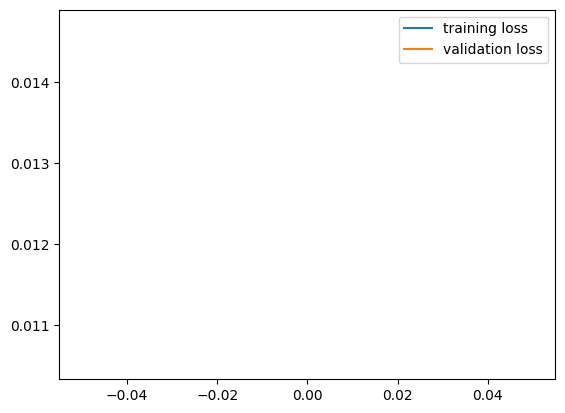

Train Epoch: 1 [0/534940 (0%)]	Loss: 1.196811
Train Epoch: 1 [6400/534940 (1%)]	Loss: 0.191551
Train Epoch: 1 [12800/534940 (2%)]	Loss: 0.105710
Train Epoch: 1 [19200/534940 (4%)]	Loss: 0.470603
Train Epoch: 1 [25600/534940 (5%)]	Loss: 0.120827
Train Epoch: 1 [32000/534940 (6%)]	Loss: 0.183494
Train Epoch: 1 [38400/534940 (7%)]	Loss: 0.432025
Train Epoch: 1 [44800/534940 (8%)]	Loss: 0.167436
Train Epoch: 1 [51200/534940 (10%)]	Loss: 0.111277
Train Epoch: 1 [57600/534940 (11%)]	Loss: 0.420717
Train Epoch: 1 [64000/534940 (12%)]	Loss: 0.448024
Train Epoch: 1 [70400/534940 (13%)]	Loss: 1.116253
Train Epoch: 1 [76800/534940 (14%)]	Loss: 0.249856
Train Epoch: 1 [83200/534940 (16%)]	Loss: 0.180876
Train Epoch: 1 [89600/534940 (17%)]	Loss: 0.376810
Train Epoch: 1 [96000/534940 (18%)]	Loss: 1.308365
Train Epoch: 1 [102400/534940 (19%)]	Loss: 0.122235
Train Epoch: 1 [108800/534940 (20%)]	Loss: 0.614842
Train Epoch: 1 [115200/534940 (22%)]	Loss: 0.514292
Train Epoch: 1 [121600/534940 (23%)]	Loss

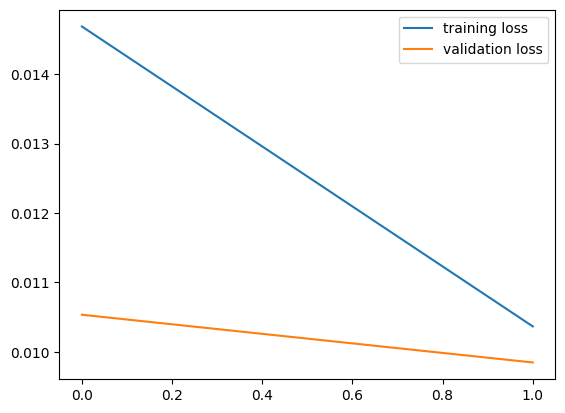

Train Epoch: 2 [0/534940 (0%)]	Loss: 0.299405
Train Epoch: 2 [6400/534940 (1%)]	Loss: 0.328656
Train Epoch: 2 [12800/534940 (2%)]	Loss: 0.144498
Train Epoch: 2 [19200/534940 (4%)]	Loss: 0.496747
Train Epoch: 2 [25600/534940 (5%)]	Loss: 0.156793
Train Epoch: 2 [32000/534940 (6%)]	Loss: 0.078447
Train Epoch: 2 [38400/534940 (7%)]	Loss: 0.253145
Train Epoch: 2 [44800/534940 (8%)]	Loss: 0.195561
Train Epoch: 2 [51200/534940 (10%)]	Loss: 0.312740
Train Epoch: 2 [57600/534940 (11%)]	Loss: 0.531860
Train Epoch: 2 [64000/534940 (12%)]	Loss: 1.655402
Train Epoch: 2 [70400/534940 (13%)]	Loss: 0.276222
Train Epoch: 2 [76800/534940 (14%)]	Loss: 0.173601
Train Epoch: 2 [83200/534940 (16%)]	Loss: 2.299033
Train Epoch: 2 [89600/534940 (17%)]	Loss: 0.213898
Train Epoch: 2 [96000/534940 (18%)]	Loss: 0.325676
Train Epoch: 2 [102400/534940 (19%)]	Loss: 0.275572
Train Epoch: 2 [108800/534940 (20%)]	Loss: 4.148471
Train Epoch: 2 [115200/534940 (22%)]	Loss: 1.135628
Train Epoch: 2 [121600/534940 (23%)]	Loss

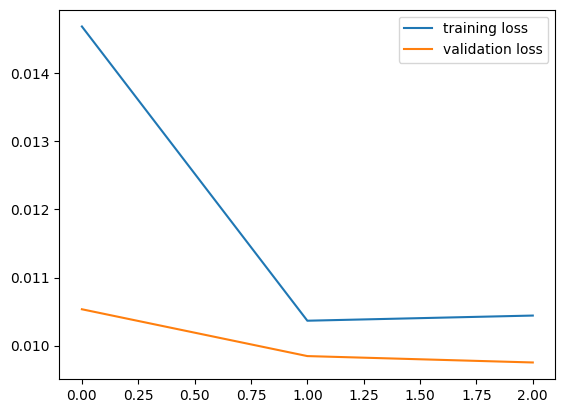

Train Epoch: 3 [0/534940 (0%)]	Loss: 0.433492
Train Epoch: 3 [6400/534940 (1%)]	Loss: 0.218460
Train Epoch: 3 [12800/534940 (2%)]	Loss: 0.148953
Train Epoch: 3 [19200/534940 (4%)]	Loss: 0.061346
Train Epoch: 3 [25600/534940 (5%)]	Loss: 0.625235
Train Epoch: 3 [32000/534940 (6%)]	Loss: 0.235443
Train Epoch: 3 [38400/534940 (7%)]	Loss: 0.085762
Train Epoch: 3 [44800/534940 (8%)]	Loss: 0.448283
Train Epoch: 3 [51200/534940 (10%)]	Loss: 0.932065
Train Epoch: 3 [57600/534940 (11%)]	Loss: 0.105549
Train Epoch: 3 [64000/534940 (12%)]	Loss: 0.148234
Train Epoch: 3 [70400/534940 (13%)]	Loss: 0.190398
Train Epoch: 3 [76800/534940 (14%)]	Loss: 0.799354
Train Epoch: 3 [83200/534940 (16%)]	Loss: 1.140372
Train Epoch: 3 [89600/534940 (17%)]	Loss: 0.469870
Train Epoch: 3 [96000/534940 (18%)]	Loss: 0.140803
Train Epoch: 3 [102400/534940 (19%)]	Loss: 0.425555
Train Epoch: 3 [108800/534940 (20%)]	Loss: 0.293520
Train Epoch: 3 [115200/534940 (22%)]	Loss: 0.693163
Train Epoch: 3 [121600/534940 (23%)]	Loss

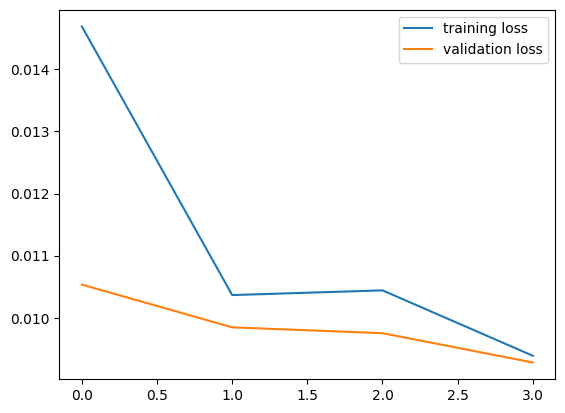

Train Epoch: 4 [0/534940 (0%)]	Loss: 0.140863
Train Epoch: 4 [6400/534940 (1%)]	Loss: 0.401837
Train Epoch: 4 [12800/534940 (2%)]	Loss: 0.085886
Train Epoch: 4 [19200/534940 (4%)]	Loss: 0.547042
Train Epoch: 4 [25600/534940 (5%)]	Loss: 0.840028
Train Epoch: 4 [32000/534940 (6%)]	Loss: 2.787802
Train Epoch: 4 [38400/534940 (7%)]	Loss: 0.340510
Train Epoch: 4 [44800/534940 (8%)]	Loss: 0.080109
Train Epoch: 4 [51200/534940 (10%)]	Loss: 0.155073
Train Epoch: 4 [57600/534940 (11%)]	Loss: 0.212355
Train Epoch: 4 [64000/534940 (12%)]	Loss: 0.277585
Train Epoch: 4 [70400/534940 (13%)]	Loss: 0.224229
Train Epoch: 4 [76800/534940 (14%)]	Loss: 0.413225
Train Epoch: 4 [83200/534940 (16%)]	Loss: 0.177560
Train Epoch: 4 [89600/534940 (17%)]	Loss: 0.815105
Train Epoch: 4 [96000/534940 (18%)]	Loss: 0.218918
Train Epoch: 4 [102400/534940 (19%)]	Loss: 0.116551
Train Epoch: 4 [108800/534940 (20%)]	Loss: 0.142530
Train Epoch: 4 [115200/534940 (22%)]	Loss: 0.346002
Train Epoch: 4 [121600/534940 (23%)]	Loss

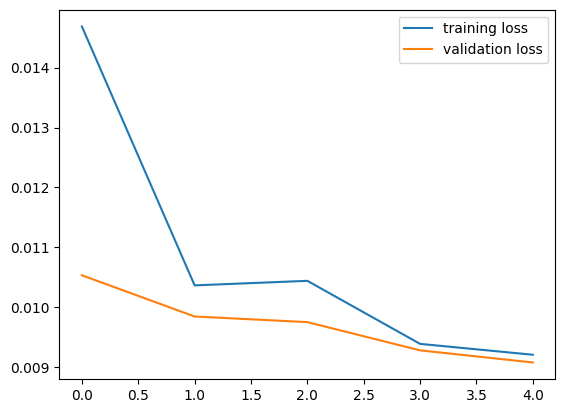

Train Epoch: 5 [0/534940 (0%)]	Loss: 0.042015
Train Epoch: 5 [6400/534940 (1%)]	Loss: 0.144720
Train Epoch: 5 [12800/534940 (2%)]	Loss: 0.290615
Train Epoch: 5 [19200/534940 (4%)]	Loss: 0.784685
Train Epoch: 5 [25600/534940 (5%)]	Loss: 0.177013
Train Epoch: 5 [32000/534940 (6%)]	Loss: 0.133787
Train Epoch: 5 [38400/534940 (7%)]	Loss: 0.415362
Train Epoch: 5 [44800/534940 (8%)]	Loss: 1.272066
Train Epoch: 5 [51200/534940 (10%)]	Loss: 0.471171
Train Epoch: 5 [57600/534940 (11%)]	Loss: 0.857412
Train Epoch: 5 [64000/534940 (12%)]	Loss: 0.133919
Train Epoch: 5 [70400/534940 (13%)]	Loss: 0.675254
Train Epoch: 5 [76800/534940 (14%)]	Loss: 0.349134
Train Epoch: 5 [83200/534940 (16%)]	Loss: 0.142209
Train Epoch: 5 [89600/534940 (17%)]	Loss: 0.352428
Train Epoch: 5 [96000/534940 (18%)]	Loss: 0.320946
Train Epoch: 5 [102400/534940 (19%)]	Loss: 0.762050
Train Epoch: 5 [108800/534940 (20%)]	Loss: 0.579149
Train Epoch: 5 [115200/534940 (22%)]	Loss: 0.405147
Train Epoch: 5 [121600/534940 (23%)]	Loss

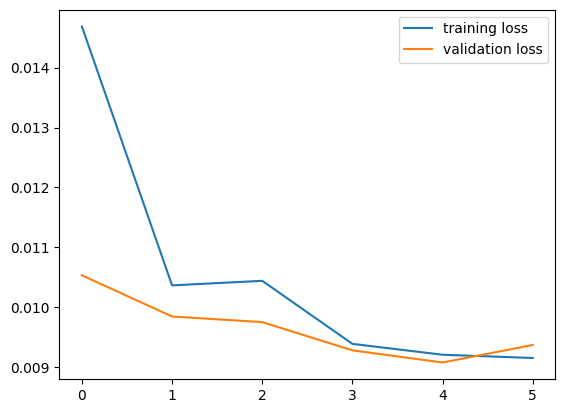

Train Epoch: 6 [0/534940 (0%)]	Loss: 0.955305
Train Epoch: 6 [6400/534940 (1%)]	Loss: 0.099048
Train Epoch: 6 [12800/534940 (2%)]	Loss: 0.172398
Train Epoch: 6 [19200/534940 (4%)]	Loss: 0.091368
Train Epoch: 6 [25600/534940 (5%)]	Loss: 0.335074
Train Epoch: 6 [32000/534940 (6%)]	Loss: 0.116624
Train Epoch: 6 [38400/534940 (7%)]	Loss: 0.479874
Train Epoch: 6 [44800/534940 (8%)]	Loss: 1.103824
Train Epoch: 6 [51200/534940 (10%)]	Loss: 0.272035
Train Epoch: 6 [57600/534940 (11%)]	Loss: 0.569179
Train Epoch: 6 [64000/534940 (12%)]	Loss: 1.064138
Train Epoch: 6 [70400/534940 (13%)]	Loss: 2.206273
Train Epoch: 6 [76800/534940 (14%)]	Loss: 0.157600
Train Epoch: 6 [83200/534940 (16%)]	Loss: 0.204358
Train Epoch: 6 [89600/534940 (17%)]	Loss: 0.260104
Train Epoch: 6 [96000/534940 (18%)]	Loss: 0.288305
Train Epoch: 6 [102400/534940 (19%)]	Loss: 0.333280
Train Epoch: 6 [108800/534940 (20%)]	Loss: 0.309323
Train Epoch: 6 [115200/534940 (22%)]	Loss: 0.191440
Train Epoch: 6 [121600/534940 (23%)]	Loss

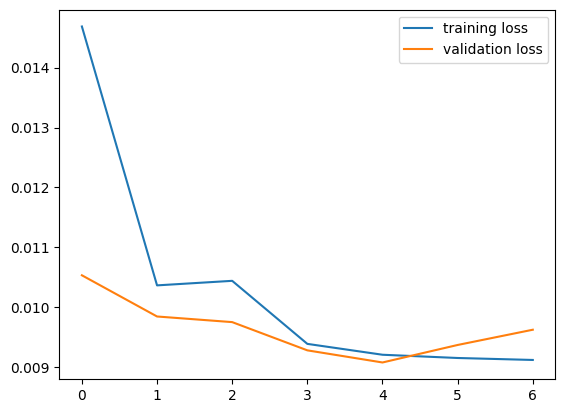

Train Epoch: 7 [0/534940 (0%)]	Loss: 0.382994
Train Epoch: 7 [6400/534940 (1%)]	Loss: 0.310069
Train Epoch: 7 [12800/534940 (2%)]	Loss: 0.119693
Train Epoch: 7 [19200/534940 (4%)]	Loss: 0.252080
Train Epoch: 7 [25600/534940 (5%)]	Loss: 0.345964
Train Epoch: 7 [32000/534940 (6%)]	Loss: 0.112752
Train Epoch: 7 [38400/534940 (7%)]	Loss: 0.195339
Train Epoch: 7 [44800/534940 (8%)]	Loss: 0.478406
Train Epoch: 7 [51200/534940 (10%)]	Loss: 3.150313
Train Epoch: 7 [57600/534940 (11%)]	Loss: 0.161545
Train Epoch: 7 [64000/534940 (12%)]	Loss: 0.345540
Train Epoch: 7 [70400/534940 (13%)]	Loss: 0.338478
Train Epoch: 7 [76800/534940 (14%)]	Loss: 0.500613
Train Epoch: 7 [83200/534940 (16%)]	Loss: 0.122416
Train Epoch: 7 [89600/534940 (17%)]	Loss: 0.187720
Train Epoch: 7 [96000/534940 (18%)]	Loss: 0.274127
Train Epoch: 7 [102400/534940 (19%)]	Loss: 0.364429
Train Epoch: 7 [108800/534940 (20%)]	Loss: 0.118131
Train Epoch: 7 [115200/534940 (22%)]	Loss: 0.098376
Train Epoch: 7 [121600/534940 (23%)]	Loss

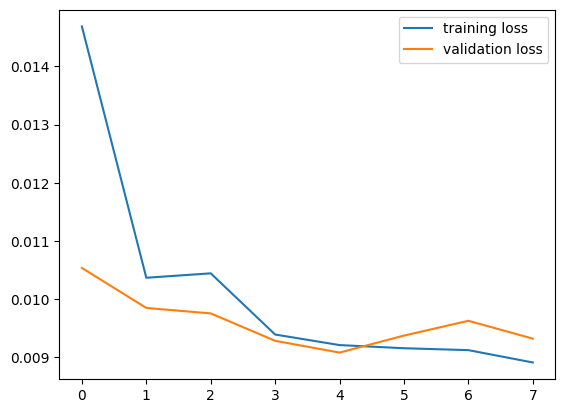

Train Epoch: 8 [0/534940 (0%)]	Loss: 0.612620
Train Epoch: 8 [6400/534940 (1%)]	Loss: 0.158305
Train Epoch: 8 [12800/534940 (2%)]	Loss: 0.071310
Train Epoch: 8 [19200/534940 (4%)]	Loss: 0.314783
Train Epoch: 8 [25600/534940 (5%)]	Loss: 0.341840
Train Epoch: 8 [32000/534940 (6%)]	Loss: 0.394149
Train Epoch: 8 [38400/534940 (7%)]	Loss: 0.206351
Train Epoch: 8 [44800/534940 (8%)]	Loss: 0.974493
Train Epoch: 8 [51200/534940 (10%)]	Loss: 0.726540
Train Epoch: 8 [57600/534940 (11%)]	Loss: 0.969145
Train Epoch: 8 [64000/534940 (12%)]	Loss: 0.128172
Train Epoch: 8 [70400/534940 (13%)]	Loss: 0.512177
Train Epoch: 8 [76800/534940 (14%)]	Loss: 0.410546
Train Epoch: 8 [83200/534940 (16%)]	Loss: 0.229813
Train Epoch: 8 [89600/534940 (17%)]	Loss: 0.710439
Train Epoch: 8 [96000/534940 (18%)]	Loss: 0.155619
Train Epoch: 8 [102400/534940 (19%)]	Loss: 0.152556
Train Epoch: 8 [108800/534940 (20%)]	Loss: 0.462464
Train Epoch: 8 [115200/534940 (22%)]	Loss: 0.086398
Train Epoch: 8 [121600/534940 (23%)]	Loss

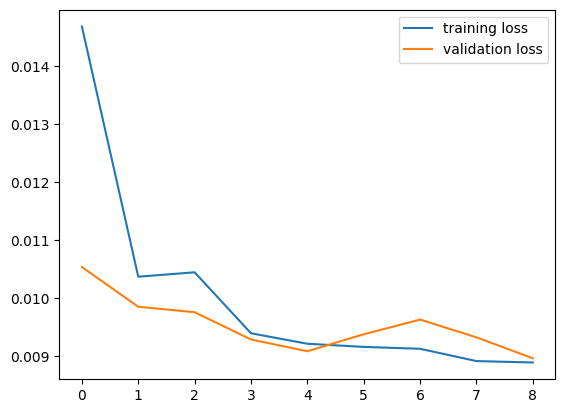

Train Epoch: 9 [0/534940 (0%)]	Loss: 0.723588
Train Epoch: 9 [6400/534940 (1%)]	Loss: 0.409200
Train Epoch: 9 [12800/534940 (2%)]	Loss: 0.417148
Train Epoch: 9 [19200/534940 (4%)]	Loss: 0.357296
Train Epoch: 9 [25600/534940 (5%)]	Loss: 0.197191
Train Epoch: 9 [32000/534940 (6%)]	Loss: 0.085467
Train Epoch: 9 [38400/534940 (7%)]	Loss: 0.357204
Train Epoch: 9 [44800/534940 (8%)]	Loss: 0.371939
Train Epoch: 9 [51200/534940 (10%)]	Loss: 0.224061
Train Epoch: 9 [57600/534940 (11%)]	Loss: 0.234121
Train Epoch: 9 [64000/534940 (12%)]	Loss: 0.310459
Train Epoch: 9 [70400/534940 (13%)]	Loss: 0.090275
Train Epoch: 9 [76800/534940 (14%)]	Loss: 1.423690
Train Epoch: 9 [83200/534940 (16%)]	Loss: 2.814262
Train Epoch: 9 [89600/534940 (17%)]	Loss: 0.120314
Train Epoch: 9 [96000/534940 (18%)]	Loss: 0.135164
Train Epoch: 9 [102400/534940 (19%)]	Loss: 0.317781
Train Epoch: 9 [108800/534940 (20%)]	Loss: 0.190277
Train Epoch: 9 [115200/534940 (22%)]	Loss: 0.267591
Train Epoch: 9 [121600/534940 (23%)]	Loss

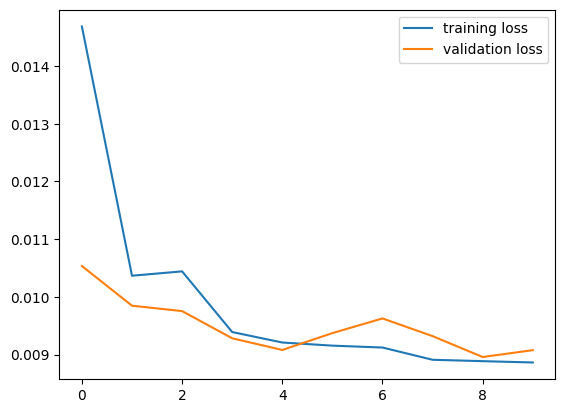

Train Epoch: 10 [0/534940 (0%)]	Loss: 0.139209
Train Epoch: 10 [6400/534940 (1%)]	Loss: 0.197413
Train Epoch: 10 [12800/534940 (2%)]	Loss: 0.217316
Train Epoch: 10 [19200/534940 (4%)]	Loss: 0.813381
Train Epoch: 10 [25600/534940 (5%)]	Loss: 0.048677
Train Epoch: 10 [32000/534940 (6%)]	Loss: 0.786710
Train Epoch: 10 [38400/534940 (7%)]	Loss: 0.112560
Train Epoch: 10 [44800/534940 (8%)]	Loss: 0.132790
Train Epoch: 10 [51200/534940 (10%)]	Loss: 0.186914
Train Epoch: 10 [57600/534940 (11%)]	Loss: 0.323612
Train Epoch: 10 [64000/534940 (12%)]	Loss: 0.161914
Train Epoch: 10 [70400/534940 (13%)]	Loss: 0.142667
Train Epoch: 10 [76800/534940 (14%)]	Loss: 1.833782
Train Epoch: 10 [83200/534940 (16%)]	Loss: 0.123270
Train Epoch: 10 [89600/534940 (17%)]	Loss: 0.660204
Train Epoch: 10 [96000/534940 (18%)]	Loss: 0.245733
Train Epoch: 10 [102400/534940 (19%)]	Loss: 0.404825
Train Epoch: 10 [108800/534940 (20%)]	Loss: 0.323715
Train Epoch: 10 [115200/534940 (22%)]	Loss: 0.464472
Train Epoch: 10 [12160

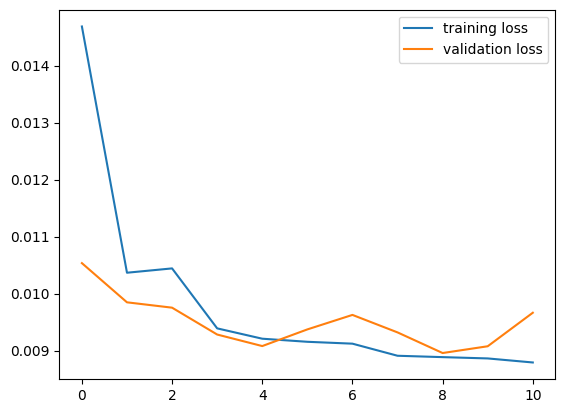

Train Epoch: 11 [0/534940 (0%)]	Loss: 0.183382
Train Epoch: 11 [6400/534940 (1%)]	Loss: 0.155258
Train Epoch: 11 [12800/534940 (2%)]	Loss: 0.542837
Train Epoch: 11 [19200/534940 (4%)]	Loss: 0.443282
Train Epoch: 11 [25600/534940 (5%)]	Loss: 0.183059
Train Epoch: 11 [32000/534940 (6%)]	Loss: 0.209919
Train Epoch: 11 [38400/534940 (7%)]	Loss: 0.417890
Train Epoch: 11 [44800/534940 (8%)]	Loss: 0.200366
Train Epoch: 11 [51200/534940 (10%)]	Loss: 0.171301
Train Epoch: 11 [57600/534940 (11%)]	Loss: 0.157718
Train Epoch: 11 [64000/534940 (12%)]	Loss: 0.260444
Train Epoch: 11 [70400/534940 (13%)]	Loss: 0.116022
Train Epoch: 11 [76800/534940 (14%)]	Loss: 0.115205
Train Epoch: 11 [83200/534940 (16%)]	Loss: 0.122439
Train Epoch: 11 [89600/534940 (17%)]	Loss: 0.161488
Train Epoch: 11 [96000/534940 (18%)]	Loss: 0.214938
Train Epoch: 11 [102400/534940 (19%)]	Loss: 0.219543
Train Epoch: 11 [108800/534940 (20%)]	Loss: 0.618977
Train Epoch: 11 [115200/534940 (22%)]	Loss: 0.160131
Train Epoch: 11 [12160

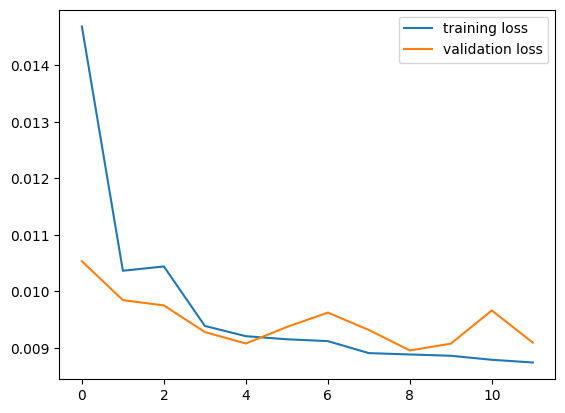

Train Epoch: 12 [0/534940 (0%)]	Loss: 0.094233
Train Epoch: 12 [6400/534940 (1%)]	Loss: 0.256743
Train Epoch: 12 [12800/534940 (2%)]	Loss: 1.176770
Train Epoch: 12 [19200/534940 (4%)]	Loss: 0.252833
Train Epoch: 12 [25600/534940 (5%)]	Loss: 0.108867
Train Epoch: 12 [32000/534940 (6%)]	Loss: 0.369528
Train Epoch: 12 [38400/534940 (7%)]	Loss: 1.149189
Train Epoch: 12 [44800/534940 (8%)]	Loss: 0.669819
Train Epoch: 12 [51200/534940 (10%)]	Loss: 0.063436
Train Epoch: 12 [57600/534940 (11%)]	Loss: 0.750905
Train Epoch: 12 [64000/534940 (12%)]	Loss: 0.401455
Train Epoch: 12 [70400/534940 (13%)]	Loss: 0.087898
Train Epoch: 12 [76800/534940 (14%)]	Loss: 0.272138
Train Epoch: 12 [83200/534940 (16%)]	Loss: 0.196897
Train Epoch: 12 [89600/534940 (17%)]	Loss: 0.139767
Train Epoch: 12 [96000/534940 (18%)]	Loss: 0.062513
Train Epoch: 12 [102400/534940 (19%)]	Loss: 2.246067
Train Epoch: 12 [108800/534940 (20%)]	Loss: 0.246471
Train Epoch: 12 [115200/534940 (22%)]	Loss: 0.080782
Train Epoch: 12 [12160

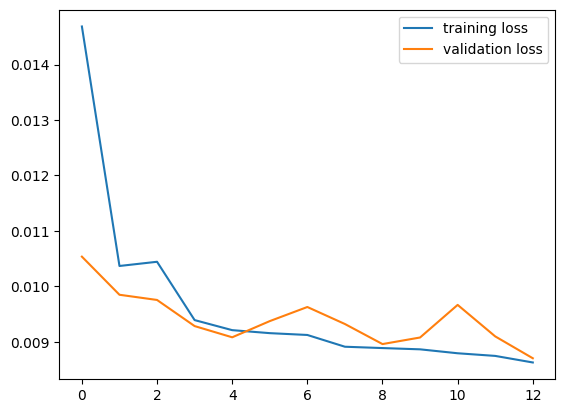

Train Epoch: 13 [0/534940 (0%)]	Loss: 0.507637
Train Epoch: 13 [6400/534940 (1%)]	Loss: 0.098482
Train Epoch: 13 [12800/534940 (2%)]	Loss: 0.078811
Train Epoch: 13 [19200/534940 (4%)]	Loss: 0.113152
Train Epoch: 13 [25600/534940 (5%)]	Loss: 0.189705
Train Epoch: 13 [32000/534940 (6%)]	Loss: 0.159670
Train Epoch: 13 [38400/534940 (7%)]	Loss: 0.320238
Train Epoch: 13 [44800/534940 (8%)]	Loss: 0.820411
Train Epoch: 13 [51200/534940 (10%)]	Loss: 0.066163
Train Epoch: 13 [57600/534940 (11%)]	Loss: 0.096397
Train Epoch: 13 [64000/534940 (12%)]	Loss: 0.979385
Train Epoch: 13 [70400/534940 (13%)]	Loss: 1.500760
Train Epoch: 13 [76800/534940 (14%)]	Loss: 0.142955
Train Epoch: 13 [83200/534940 (16%)]	Loss: 0.526637
Train Epoch: 13 [89600/534940 (17%)]	Loss: 0.150978
Train Epoch: 13 [96000/534940 (18%)]	Loss: 0.165197
Train Epoch: 13 [102400/534940 (19%)]	Loss: 0.431529
Train Epoch: 13 [108800/534940 (20%)]	Loss: 0.407423
Train Epoch: 13 [115200/534940 (22%)]	Loss: 0.925632
Train Epoch: 13 [12160

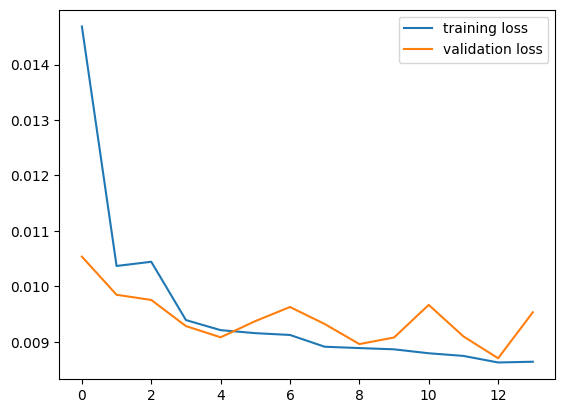

Train Epoch: 14 [0/534940 (0%)]	Loss: 0.068378
Train Epoch: 14 [6400/534940 (1%)]	Loss: 0.258332
Train Epoch: 14 [12800/534940 (2%)]	Loss: 0.631677
Train Epoch: 14 [19200/534940 (4%)]	Loss: 0.197598
Train Epoch: 14 [25600/534940 (5%)]	Loss: 0.611610
Train Epoch: 14 [32000/534940 (6%)]	Loss: 0.067569
Train Epoch: 14 [38400/534940 (7%)]	Loss: 0.195108
Train Epoch: 14 [44800/534940 (8%)]	Loss: 0.269261
Train Epoch: 14 [51200/534940 (10%)]	Loss: 0.171772
Train Epoch: 14 [57600/534940 (11%)]	Loss: 0.203165
Train Epoch: 14 [64000/534940 (12%)]	Loss: 0.043837
Train Epoch: 14 [70400/534940 (13%)]	Loss: 0.067662
Train Epoch: 14 [76800/534940 (14%)]	Loss: 0.699466
Train Epoch: 14 [83200/534940 (16%)]	Loss: 0.122643
Train Epoch: 14 [89600/534940 (17%)]	Loss: 0.593659
Train Epoch: 14 [96000/534940 (18%)]	Loss: 0.137634
Train Epoch: 14 [102400/534940 (19%)]	Loss: 0.722847
Train Epoch: 14 [108800/534940 (20%)]	Loss: 0.926186
Train Epoch: 14 [115200/534940 (22%)]	Loss: 0.244958
Train Epoch: 14 [12160

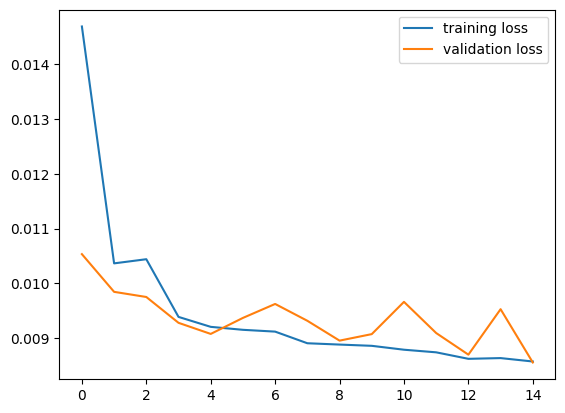

Train Epoch: 15 [0/534940 (0%)]	Loss: 0.208933
Train Epoch: 15 [6400/534940 (1%)]	Loss: 1.274095
Train Epoch: 15 [12800/534940 (2%)]	Loss: 0.325087
Train Epoch: 15 [19200/534940 (4%)]	Loss: 0.139134
Train Epoch: 15 [25600/534940 (5%)]	Loss: 0.080078
Train Epoch: 15 [32000/534940 (6%)]	Loss: 0.927885
Train Epoch: 15 [38400/534940 (7%)]	Loss: 1.193903
Train Epoch: 15 [44800/534940 (8%)]	Loss: 0.585564
Train Epoch: 15 [51200/534940 (10%)]	Loss: 1.613135
Train Epoch: 15 [57600/534940 (11%)]	Loss: 0.224882
Train Epoch: 15 [64000/534940 (12%)]	Loss: 0.078979
Train Epoch: 15 [70400/534940 (13%)]	Loss: 0.248212
Train Epoch: 15 [76800/534940 (14%)]	Loss: 0.196444
Train Epoch: 15 [83200/534940 (16%)]	Loss: 0.221278
Train Epoch: 15 [89600/534940 (17%)]	Loss: 0.132926
Train Epoch: 15 [96000/534940 (18%)]	Loss: 0.341241
Train Epoch: 15 [102400/534940 (19%)]	Loss: 0.381537
Train Epoch: 15 [108800/534940 (20%)]	Loss: 0.160661
Train Epoch: 15 [115200/534940 (22%)]	Loss: 0.250481
Train Epoch: 15 [12160

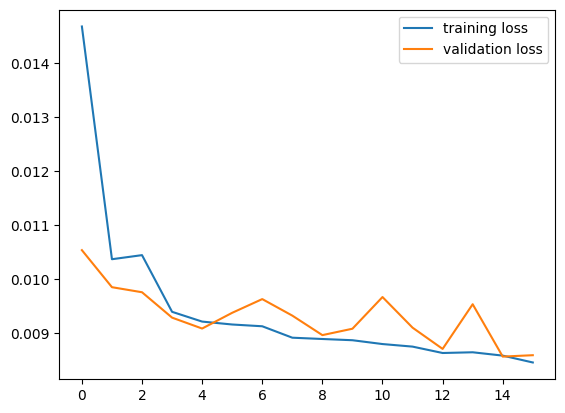

Train Epoch: 16 [0/534940 (0%)]	Loss: 0.295325
Train Epoch: 16 [6400/534940 (1%)]	Loss: 1.807880
Train Epoch: 16 [12800/534940 (2%)]	Loss: 0.429522
Train Epoch: 16 [19200/534940 (4%)]	Loss: 0.246148
Train Epoch: 16 [25600/534940 (5%)]	Loss: 0.693851
Train Epoch: 16 [32000/534940 (6%)]	Loss: 0.191119
Train Epoch: 16 [38400/534940 (7%)]	Loss: 0.229198
Train Epoch: 16 [44800/534940 (8%)]	Loss: 0.219213
Train Epoch: 16 [51200/534940 (10%)]	Loss: 4.103756
Train Epoch: 16 [57600/534940 (11%)]	Loss: 0.109134
Train Epoch: 16 [64000/534940 (12%)]	Loss: 0.915965
Train Epoch: 16 [70400/534940 (13%)]	Loss: 0.140904
Train Epoch: 16 [76800/534940 (14%)]	Loss: 0.109195
Train Epoch: 16 [83200/534940 (16%)]	Loss: 0.150047
Train Epoch: 16 [89600/534940 (17%)]	Loss: 0.759317
Train Epoch: 16 [96000/534940 (18%)]	Loss: 0.226576
Train Epoch: 16 [102400/534940 (19%)]	Loss: 0.167988
Train Epoch: 16 [108800/534940 (20%)]	Loss: 0.362219
Train Epoch: 16 [115200/534940 (22%)]	Loss: 0.145249
Train Epoch: 16 [12160

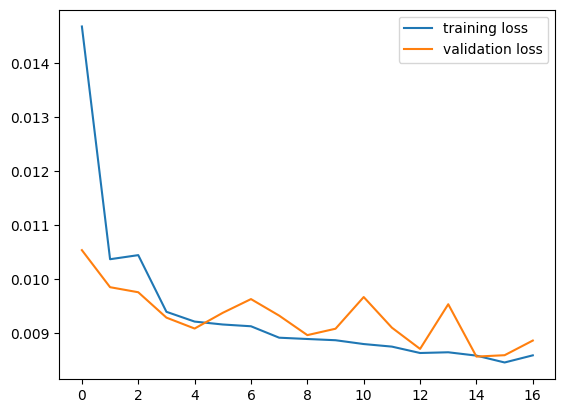

Train Epoch: 17 [0/534940 (0%)]	Loss: 0.275324
Train Epoch: 17 [6400/534940 (1%)]	Loss: 0.106007
Train Epoch: 17 [12800/534940 (2%)]	Loss: 0.210228
Train Epoch: 17 [19200/534940 (4%)]	Loss: 0.637221
Train Epoch: 17 [25600/534940 (5%)]	Loss: 0.179712
Train Epoch: 17 [32000/534940 (6%)]	Loss: 0.442953
Train Epoch: 17 [38400/534940 (7%)]	Loss: 0.141957
Train Epoch: 17 [44800/534940 (8%)]	Loss: 0.256686
Train Epoch: 17 [51200/534940 (10%)]	Loss: 0.309656
Train Epoch: 17 [57600/534940 (11%)]	Loss: 0.609396
Train Epoch: 17 [64000/534940 (12%)]	Loss: 0.087604
Train Epoch: 17 [70400/534940 (13%)]	Loss: 0.203011
Train Epoch: 17 [76800/534940 (14%)]	Loss: 0.313598
Train Epoch: 17 [83200/534940 (16%)]	Loss: 0.217412
Train Epoch: 17 [89600/534940 (17%)]	Loss: 0.167086
Train Epoch: 17 [96000/534940 (18%)]	Loss: 0.111993
Train Epoch: 17 [102400/534940 (19%)]	Loss: 0.075983
Train Epoch: 17 [108800/534940 (20%)]	Loss: 0.330405
Train Epoch: 17 [115200/534940 (22%)]	Loss: 0.177829
Train Epoch: 17 [12160

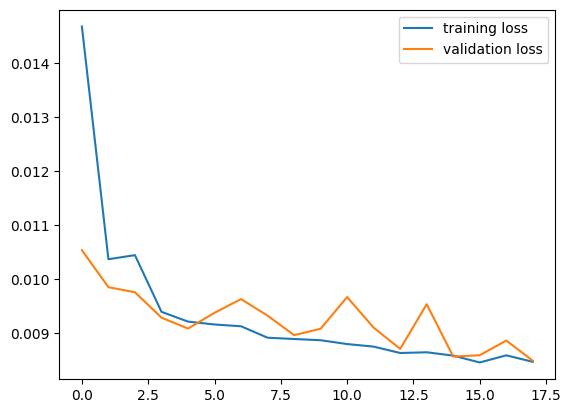

Train Epoch: 18 [0/534940 (0%)]	Loss: 0.096500
Train Epoch: 18 [6400/534940 (1%)]	Loss: 0.115968
Train Epoch: 18 [12800/534940 (2%)]	Loss: 0.295167
Train Epoch: 18 [19200/534940 (4%)]	Loss: 0.845633
Train Epoch: 18 [25600/534940 (5%)]	Loss: 0.117805
Train Epoch: 18 [32000/534940 (6%)]	Loss: 0.466159
Train Epoch: 18 [38400/534940 (7%)]	Loss: 0.237421
Train Epoch: 18 [44800/534940 (8%)]	Loss: 0.065103
Train Epoch: 18 [51200/534940 (10%)]	Loss: 2.034248
Train Epoch: 18 [57600/534940 (11%)]	Loss: 0.125847
Train Epoch: 18 [64000/534940 (12%)]	Loss: 0.224548
Train Epoch: 18 [70400/534940 (13%)]	Loss: 0.203271
Train Epoch: 18 [76800/534940 (14%)]	Loss: 0.148645
Train Epoch: 18 [83200/534940 (16%)]	Loss: 0.612150
Train Epoch: 18 [89600/534940 (17%)]	Loss: 0.155427
Train Epoch: 18 [96000/534940 (18%)]	Loss: 0.303607
Train Epoch: 18 [102400/534940 (19%)]	Loss: 0.515751
Train Epoch: 18 [108800/534940 (20%)]	Loss: 0.218448
Train Epoch: 18 [115200/534940 (22%)]	Loss: 0.264701
Train Epoch: 18 [12160

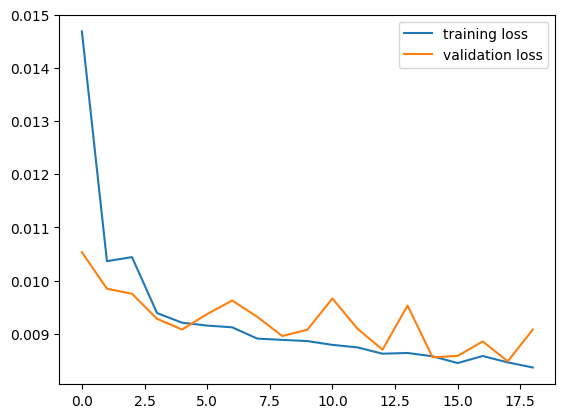

Train Epoch: 19 [0/534940 (0%)]	Loss: 0.301899
Train Epoch: 19 [6400/534940 (1%)]	Loss: 0.327457
Train Epoch: 19 [12800/534940 (2%)]	Loss: 1.758392
Train Epoch: 19 [19200/534940 (4%)]	Loss: 0.191278
Train Epoch: 19 [25600/534940 (5%)]	Loss: 0.368243
Train Epoch: 19 [32000/534940 (6%)]	Loss: 0.715430
Train Epoch: 19 [38400/534940 (7%)]	Loss: 0.111497
Train Epoch: 19 [44800/534940 (8%)]	Loss: 0.095069
Train Epoch: 19 [51200/534940 (10%)]	Loss: 0.607391
Train Epoch: 19 [57600/534940 (11%)]	Loss: 0.185522
Train Epoch: 19 [64000/534940 (12%)]	Loss: 0.073973
Train Epoch: 19 [70400/534940 (13%)]	Loss: 0.295609
Train Epoch: 19 [76800/534940 (14%)]	Loss: 0.473953
Train Epoch: 19 [83200/534940 (16%)]	Loss: 0.104411
Train Epoch: 19 [89600/534940 (17%)]	Loss: 0.341828
Train Epoch: 19 [96000/534940 (18%)]	Loss: 0.082158
Train Epoch: 19 [102400/534940 (19%)]	Loss: 0.233566
Train Epoch: 19 [108800/534940 (20%)]	Loss: 3.981635
Train Epoch: 19 [115200/534940 (22%)]	Loss: 0.104309
Train Epoch: 19 [12160

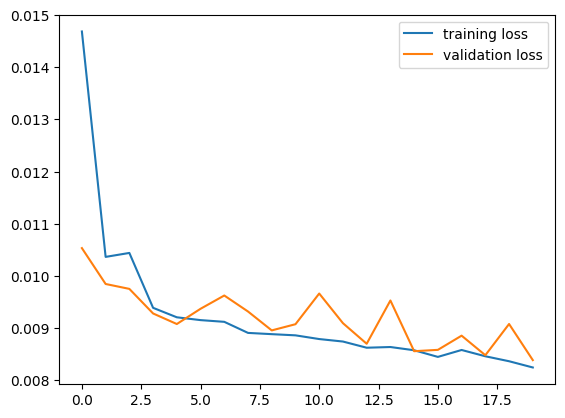

Train Epoch: 20 [0/534940 (0%)]	Loss: 0.559301
Train Epoch: 20 [6400/534940 (1%)]	Loss: 0.871406
Train Epoch: 20 [12800/534940 (2%)]	Loss: 0.150836
Train Epoch: 20 [19200/534940 (4%)]	Loss: 0.089134
Train Epoch: 20 [25600/534940 (5%)]	Loss: 0.123065
Train Epoch: 20 [32000/534940 (6%)]	Loss: 0.128751
Train Epoch: 20 [38400/534940 (7%)]	Loss: 3.123636
Train Epoch: 20 [44800/534940 (8%)]	Loss: 0.280285
Train Epoch: 20 [51200/534940 (10%)]	Loss: 0.123121
Train Epoch: 20 [57600/534940 (11%)]	Loss: 0.086677
Train Epoch: 20 [64000/534940 (12%)]	Loss: 0.427277
Train Epoch: 20 [70400/534940 (13%)]	Loss: 1.872190
Train Epoch: 20 [76800/534940 (14%)]	Loss: 0.131516
Train Epoch: 20 [83200/534940 (16%)]	Loss: 0.092822
Train Epoch: 20 [89600/534940 (17%)]	Loss: 0.119812
Train Epoch: 20 [96000/534940 (18%)]	Loss: 0.138708
Train Epoch: 20 [102400/534940 (19%)]	Loss: 0.383326
Train Epoch: 20 [108800/534940 (20%)]	Loss: 0.103281
Train Epoch: 20 [115200/534940 (22%)]	Loss: 0.192353
Train Epoch: 20 [12160

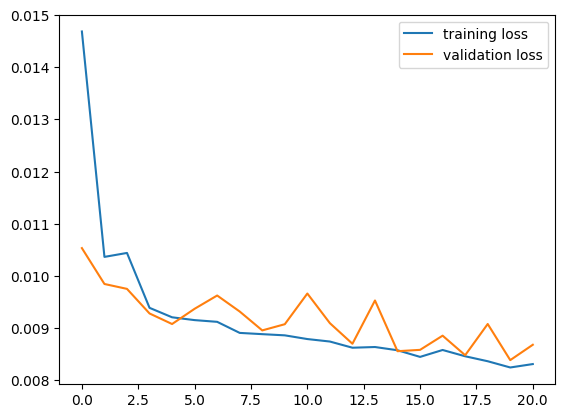

Train Epoch: 21 [0/534940 (0%)]	Loss: 0.093596
Train Epoch: 21 [6400/534940 (1%)]	Loss: 2.037762
Train Epoch: 21 [12800/534940 (2%)]	Loss: 0.131793
Train Epoch: 21 [19200/534940 (4%)]	Loss: 0.221602
Train Epoch: 21 [25600/534940 (5%)]	Loss: 0.292571
Train Epoch: 21 [32000/534940 (6%)]	Loss: 0.405447
Train Epoch: 21 [38400/534940 (7%)]	Loss: 0.467263
Train Epoch: 21 [44800/534940 (8%)]	Loss: 0.080913
Train Epoch: 21 [51200/534940 (10%)]	Loss: 0.136373
Train Epoch: 21 [57600/534940 (11%)]	Loss: 1.055828
Train Epoch: 21 [64000/534940 (12%)]	Loss: 0.282627
Train Epoch: 21 [70400/534940 (13%)]	Loss: 0.169495
Train Epoch: 21 [76800/534940 (14%)]	Loss: 0.493959
Train Epoch: 21 [83200/534940 (16%)]	Loss: 0.112199
Train Epoch: 21 [89600/534940 (17%)]	Loss: 0.250721
Train Epoch: 21 [96000/534940 (18%)]	Loss: 0.573461
Train Epoch: 21 [102400/534940 (19%)]	Loss: 0.241636
Train Epoch: 21 [108800/534940 (20%)]	Loss: 2.592006
Train Epoch: 21 [115200/534940 (22%)]	Loss: 0.232187
Train Epoch: 21 [12160

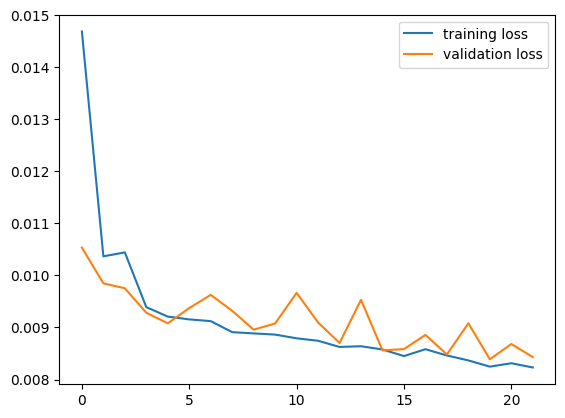

Train Epoch: 22 [0/534940 (0%)]	Loss: 0.305396
Train Epoch: 22 [6400/534940 (1%)]	Loss: 0.033895
Train Epoch: 22 [12800/534940 (2%)]	Loss: 0.507920
Train Epoch: 22 [19200/534940 (4%)]	Loss: 0.230799
Train Epoch: 22 [25600/534940 (5%)]	Loss: 0.448292
Train Epoch: 22 [32000/534940 (6%)]	Loss: 0.209787
Train Epoch: 22 [38400/534940 (7%)]	Loss: 0.375102
Train Epoch: 22 [44800/534940 (8%)]	Loss: 0.399289
Train Epoch: 22 [51200/534940 (10%)]	Loss: 0.186696
Train Epoch: 22 [57600/534940 (11%)]	Loss: 0.131381
Train Epoch: 22 [64000/534940 (12%)]	Loss: 0.190178
Train Epoch: 22 [70400/534940 (13%)]	Loss: 0.274497
Train Epoch: 22 [76800/534940 (14%)]	Loss: 0.178675
Train Epoch: 22 [83200/534940 (16%)]	Loss: 0.139260
Train Epoch: 22 [89600/534940 (17%)]	Loss: 0.733523
Train Epoch: 22 [96000/534940 (18%)]	Loss: 0.142091
Train Epoch: 22 [102400/534940 (19%)]	Loss: 0.743140
Train Epoch: 22 [108800/534940 (20%)]	Loss: 0.630331
Train Epoch: 22 [115200/534940 (22%)]	Loss: 0.530761
Train Epoch: 22 [12160

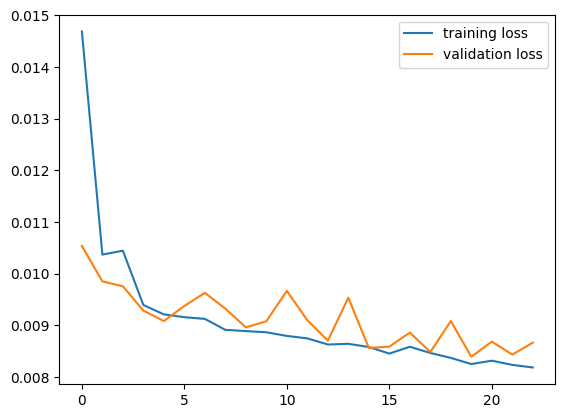

Train Epoch: 23 [0/534940 (0%)]	Loss: 0.111711
Train Epoch: 23 [6400/534940 (1%)]	Loss: 0.589768
Train Epoch: 23 [12800/534940 (2%)]	Loss: 0.229347
Train Epoch: 23 [19200/534940 (4%)]	Loss: 0.400900
Train Epoch: 23 [25600/534940 (5%)]	Loss: 0.627302
Train Epoch: 23 [32000/534940 (6%)]	Loss: 0.667114
Train Epoch: 23 [38400/534940 (7%)]	Loss: 1.796191
Train Epoch: 23 [44800/534940 (8%)]	Loss: 0.095386
Train Epoch: 23 [51200/534940 (10%)]	Loss: 0.162820
Train Epoch: 23 [57600/534940 (11%)]	Loss: 0.340962
Train Epoch: 23 [64000/534940 (12%)]	Loss: 0.538823
Train Epoch: 23 [70400/534940 (13%)]	Loss: 0.490975
Train Epoch: 23 [76800/534940 (14%)]	Loss: 0.114831
Train Epoch: 23 [83200/534940 (16%)]	Loss: 0.743736
Train Epoch: 23 [89600/534940 (17%)]	Loss: 0.258729
Train Epoch: 23 [96000/534940 (18%)]	Loss: 0.160669
Train Epoch: 23 [102400/534940 (19%)]	Loss: 0.671710
Train Epoch: 23 [108800/534940 (20%)]	Loss: 2.221706
Train Epoch: 23 [115200/534940 (22%)]	Loss: 0.359017
Train Epoch: 23 [12160

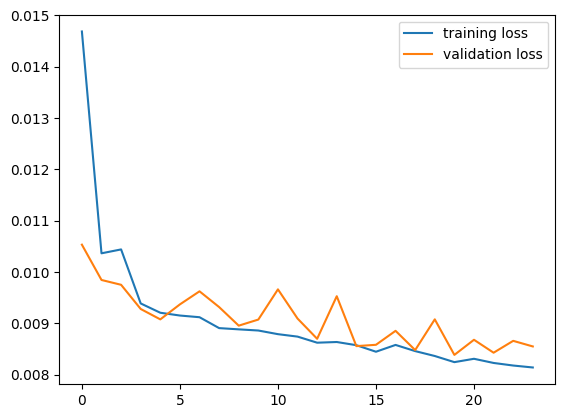

Train Epoch: 24 [0/534940 (0%)]	Loss: 0.111570
Train Epoch: 24 [6400/534940 (1%)]	Loss: 0.167188
Train Epoch: 24 [12800/534940 (2%)]	Loss: 0.496589
Train Epoch: 24 [19200/534940 (4%)]	Loss: 0.174464
Train Epoch: 24 [25600/534940 (5%)]	Loss: 0.304852
Train Epoch: 24 [32000/534940 (6%)]	Loss: 0.135987
Train Epoch: 24 [38400/534940 (7%)]	Loss: 0.157135
Train Epoch: 24 [44800/534940 (8%)]	Loss: 0.142577
Train Epoch: 24 [51200/534940 (10%)]	Loss: 0.430964
Train Epoch: 24 [57600/534940 (11%)]	Loss: 0.137077
Train Epoch: 24 [64000/534940 (12%)]	Loss: 0.268478
Train Epoch: 24 [70400/534940 (13%)]	Loss: 0.200959
Train Epoch: 24 [76800/534940 (14%)]	Loss: 0.127224
Train Epoch: 24 [83200/534940 (16%)]	Loss: 0.123052
Train Epoch: 24 [89600/534940 (17%)]	Loss: 0.146692
Train Epoch: 24 [96000/534940 (18%)]	Loss: 0.135909
Train Epoch: 24 [102400/534940 (19%)]	Loss: 0.119499
Train Epoch: 24 [108800/534940 (20%)]	Loss: 0.145108
Train Epoch: 24 [115200/534940 (22%)]	Loss: 1.732948
Train Epoch: 24 [12160

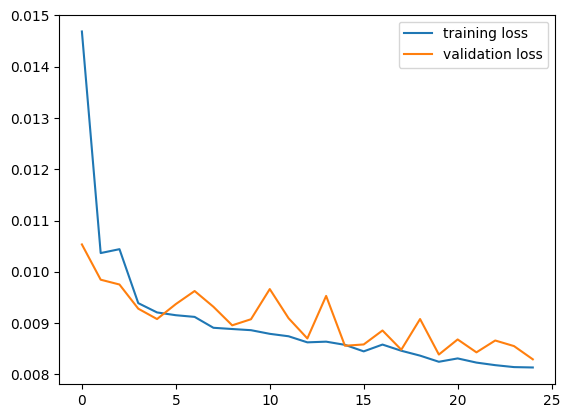

Train Epoch: 25 [0/534940 (0%)]	Loss: 0.423417
Train Epoch: 25 [6400/534940 (1%)]	Loss: 0.174656
Train Epoch: 25 [12800/534940 (2%)]	Loss: 0.681037
Train Epoch: 25 [19200/534940 (4%)]	Loss: 0.203426
Train Epoch: 25 [25600/534940 (5%)]	Loss: 0.129417
Train Epoch: 25 [32000/534940 (6%)]	Loss: 0.222867
Train Epoch: 25 [38400/534940 (7%)]	Loss: 0.071538
Train Epoch: 25 [44800/534940 (8%)]	Loss: 0.358332
Train Epoch: 25 [51200/534940 (10%)]	Loss: 0.198349
Train Epoch: 25 [57600/534940 (11%)]	Loss: 0.080074
Train Epoch: 25 [64000/534940 (12%)]	Loss: 0.671197
Train Epoch: 25 [70400/534940 (13%)]	Loss: 0.435010
Train Epoch: 25 [76800/534940 (14%)]	Loss: 0.152714
Train Epoch: 25 [83200/534940 (16%)]	Loss: 0.555450
Train Epoch: 25 [89600/534940 (17%)]	Loss: 0.506906
Train Epoch: 25 [96000/534940 (18%)]	Loss: 0.289867
Train Epoch: 25 [102400/534940 (19%)]	Loss: 0.180591
Train Epoch: 25 [108800/534940 (20%)]	Loss: 0.194666
Train Epoch: 25 [115200/534940 (22%)]	Loss: 0.245975
Train Epoch: 25 [12160

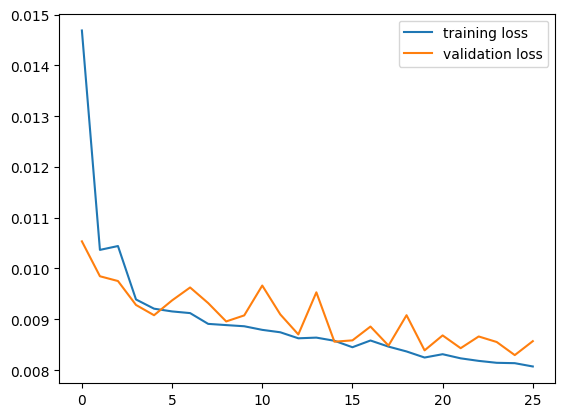

Train Epoch: 26 [0/534940 (0%)]	Loss: 0.101354
Train Epoch: 26 [6400/534940 (1%)]	Loss: 0.236581
Train Epoch: 26 [12800/534940 (2%)]	Loss: 0.169642
Train Epoch: 26 [19200/534940 (4%)]	Loss: 0.535664
Train Epoch: 26 [25600/534940 (5%)]	Loss: 0.341041
Train Epoch: 26 [32000/534940 (6%)]	Loss: 0.296205
Train Epoch: 26 [38400/534940 (7%)]	Loss: 0.336655
Train Epoch: 26 [44800/534940 (8%)]	Loss: 0.108103
Train Epoch: 26 [51200/534940 (10%)]	Loss: 0.093577
Train Epoch: 26 [57600/534940 (11%)]	Loss: 0.305224
Train Epoch: 26 [64000/534940 (12%)]	Loss: 0.184450
Train Epoch: 26 [70400/534940 (13%)]	Loss: 0.243740
Train Epoch: 26 [76800/534940 (14%)]	Loss: 1.125984
Train Epoch: 26 [83200/534940 (16%)]	Loss: 0.209759
Train Epoch: 26 [89600/534940 (17%)]	Loss: 0.566274
Train Epoch: 26 [96000/534940 (18%)]	Loss: 0.166366
Train Epoch: 26 [102400/534940 (19%)]	Loss: 0.063510
Train Epoch: 26 [108800/534940 (20%)]	Loss: 0.495453
Train Epoch: 26 [115200/534940 (22%)]	Loss: 0.193217
Train Epoch: 26 [12160

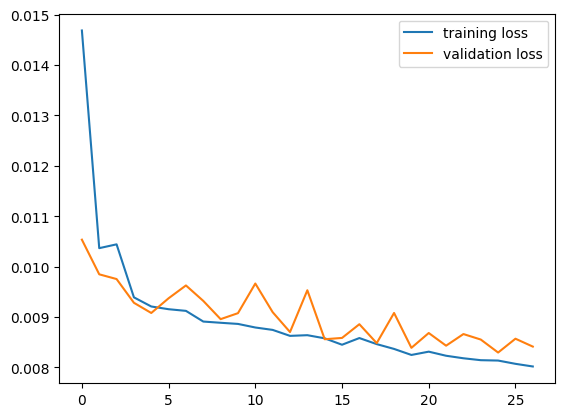

Train Epoch: 27 [0/534940 (0%)]	Loss: 0.067721
Train Epoch: 27 [6400/534940 (1%)]	Loss: 0.100254
Train Epoch: 27 [12800/534940 (2%)]	Loss: 0.153656
Train Epoch: 27 [19200/534940 (4%)]	Loss: 0.247231
Train Epoch: 27 [25600/534940 (5%)]	Loss: 0.228670
Train Epoch: 27 [32000/534940 (6%)]	Loss: 0.879127
Train Epoch: 27 [38400/534940 (7%)]	Loss: 0.099081
Train Epoch: 27 [44800/534940 (8%)]	Loss: 0.244904
Train Epoch: 27 [51200/534940 (10%)]	Loss: 0.142706
Train Epoch: 27 [57600/534940 (11%)]	Loss: 10.437045
Train Epoch: 27 [64000/534940 (12%)]	Loss: 0.229811
Train Epoch: 27 [70400/534940 (13%)]	Loss: 0.133983
Train Epoch: 27 [76800/534940 (14%)]	Loss: 0.097639
Train Epoch: 27 [83200/534940 (16%)]	Loss: 2.937767
Train Epoch: 27 [89600/534940 (17%)]	Loss: 0.284759
Train Epoch: 27 [96000/534940 (18%)]	Loss: 0.208557
Train Epoch: 27 [102400/534940 (19%)]	Loss: 1.230719
Train Epoch: 27 [108800/534940 (20%)]	Loss: 0.294939
Train Epoch: 27 [115200/534940 (22%)]	Loss: 0.655183
Train Epoch: 27 [1216

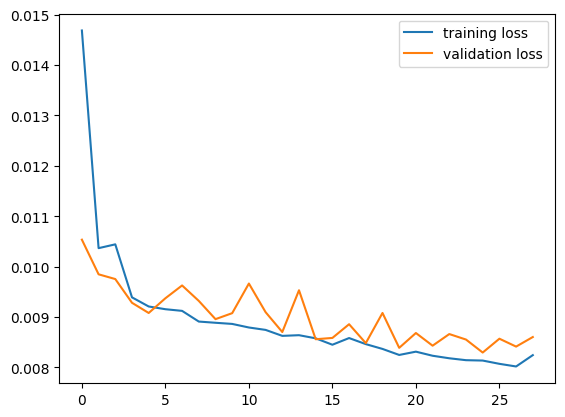

Train Epoch: 28 [0/534940 (0%)]	Loss: 0.075923
Train Epoch: 28 [6400/534940 (1%)]	Loss: 0.098330
Train Epoch: 28 [12800/534940 (2%)]	Loss: 0.108014
Train Epoch: 28 [19200/534940 (4%)]	Loss: 0.228429
Train Epoch: 28 [25600/534940 (5%)]	Loss: 0.242063
Train Epoch: 28 [32000/534940 (6%)]	Loss: 0.146944
Train Epoch: 28 [38400/534940 (7%)]	Loss: 0.274503
Train Epoch: 28 [44800/534940 (8%)]	Loss: 0.279224
Train Epoch: 28 [51200/534940 (10%)]	Loss: 0.214478
Train Epoch: 28 [57600/534940 (11%)]	Loss: 0.495041
Train Epoch: 28 [64000/534940 (12%)]	Loss: 0.154288
Train Epoch: 28 [70400/534940 (13%)]	Loss: 0.362128
Train Epoch: 28 [76800/534940 (14%)]	Loss: 0.210887
Train Epoch: 28 [83200/534940 (16%)]	Loss: 0.175040
Train Epoch: 28 [89600/534940 (17%)]	Loss: 0.079044
Train Epoch: 28 [96000/534940 (18%)]	Loss: 1.138421
Train Epoch: 28 [102400/534940 (19%)]	Loss: 0.107213
Train Epoch: 28 [108800/534940 (20%)]	Loss: 0.111595
Train Epoch: 28 [115200/534940 (22%)]	Loss: 0.086844
Train Epoch: 28 [12160

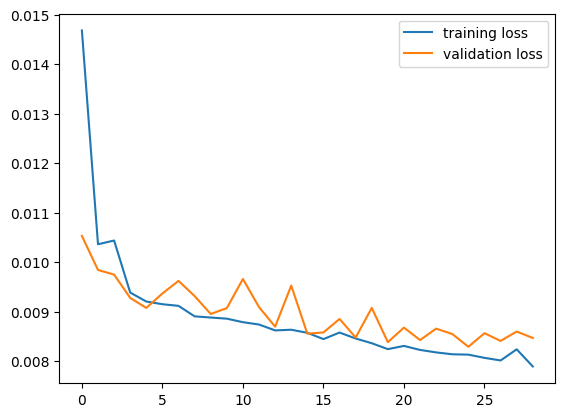

Train Epoch: 29 [0/534940 (0%)]	Loss: 5.928734
Train Epoch: 29 [6400/534940 (1%)]	Loss: 0.097592
Train Epoch: 29 [12800/534940 (2%)]	Loss: 0.449602
Train Epoch: 29 [19200/534940 (4%)]	Loss: 0.359332
Train Epoch: 29 [25600/534940 (5%)]	Loss: 0.195436
Train Epoch: 29 [32000/534940 (6%)]	Loss: 0.138762
Train Epoch: 29 [38400/534940 (7%)]	Loss: 0.143727
Train Epoch: 29 [44800/534940 (8%)]	Loss: 0.162066
Train Epoch: 29 [51200/534940 (10%)]	Loss: 0.445027
Train Epoch: 29 [57600/534940 (11%)]	Loss: 0.203841
Train Epoch: 29 [64000/534940 (12%)]	Loss: 0.153414
Train Epoch: 29 [70400/534940 (13%)]	Loss: 0.314095
Train Epoch: 29 [76800/534940 (14%)]	Loss: 0.137768
Train Epoch: 29 [83200/534940 (16%)]	Loss: 0.146904
Train Epoch: 29 [89600/534940 (17%)]	Loss: 0.326366
Train Epoch: 29 [96000/534940 (18%)]	Loss: 0.142338
Train Epoch: 29 [102400/534940 (19%)]	Loss: 0.143063
Train Epoch: 29 [108800/534940 (20%)]	Loss: 0.337932
Train Epoch: 29 [115200/534940 (22%)]	Loss: 0.158472
Train Epoch: 29 [12160

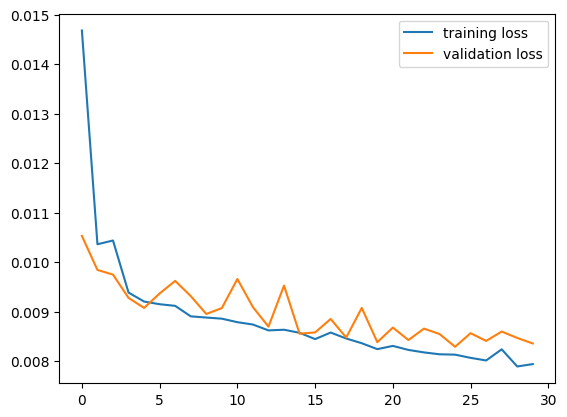

In [53]:
losses = {"train": [], "val": []}
for epoch in range(30):

    train_loss = train(epoch, criterion, MLP_model, optimizer, train_loader)
    val_loss = validate(criterion, MLP_model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [54]:
features, target = next(iter(val_loader))

In [55]:
features = features.to(device)
predicted_value = MLP_model(features)

In [56]:
(val_dataset.desnormalize(predicted_value).cpu() - val_dataset.desnormalize(target)).mean()

tensor(48112.9102, grad_fn=<MeanBackward0>)

In [57]:
(val_dataset.desnormalize(predicted_value).cpu() - val_dataset.desnormalize(target)).std()

tensor(579101.3750, grad_fn=<StdBackward0>)

In [67]:
gt_tensor = val_dataset.desnormalize(target).to(int).cpu()

In [68]:
pred_tensor = val_dataset.desnormalize(predicted_value).squeeze().to(int).cpu()

In [69]:
gt_tensor.shape

torch.Size([64])

In [70]:
pred_tensor.shape

torch.Size([64])

In [73]:
gt_numpy =gt_tensor.numpy()

In [74]:
gt_numpy

array([ 115000,  240000,  300000,  179900,   25000,  164000,  120000,
         95000,  106000,  262000,  207000,   95000,   62000, 1395000,
        190000,   72600,   37600,   66595, 2900000,  355000,   85000,
        425000,  217137,   59000,  715000,   65000,  340000,  160000,
         29000,  430000,  286000,  280000,  500000,   73000,  131500,
        111000,  530000,  114000,   56700,  127000,   89000,  365000,
        215000,  120800,   55600,   86800,  220000,  288000,  450000,
         75000,  120000,  450000,   65000,  280000,   65000,   89000,
       1799999,  103000,   35000,  247200,  130000,  139000,  139300,
         65000])

In [75]:
pred_numpy = pred_tensor.numpy()

In [76]:
pred_numpy

array([ 200611,  379543,  552146,  229616,  138379,  127043,  128384,
        164370,  240830,  230671,  331299,  220194,  210911,  610020,
        219802,  194183,  143550,   96627, 2878235,  807085,  131270,
        583680,  337691,  127084, 1058175,  105993,  657729,  183109,
        142095,  582246,  247071,  233909,  503016,  216133,  258502,
        197258,  257585,  132681,   87123,  255377,  165254,  575954,
        244948,  254979,  119765,  194578,  205751,  247241,  239228,
        119601,   97045,  477649,  145500,  712237,  147341,   99214,
        727074,  226501,  142583,  187357,  166981,  239626,  192300,
        163994])

## Anomalies detector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [99]:
range = []
anomalies = []
for i, element in enumerate(pred_numpy):
    range.append([gt_numpy[i]*0.5 , gt_numpy[i]*1.5 ])
    if (element < range[i][0] or element > range[i][1]):
        anomalies.append((i, element))



In [100]:
range

[[57500.0, 172500.0],
 [120000.0, 360000.0],
 [150000.0, 450000.0],
 [89950.0, 269850.0],
 [12500.0, 37500.0],
 [82000.0, 246000.0],
 [60000.0, 180000.0],
 [47500.0, 142500.0],
 [53000.0, 159000.0],
 [131000.0, 393000.0],
 [103500.0, 310500.0],
 [47500.0, 142500.0],
 [31000.0, 93000.0],
 [697500.0, 2092500.0],
 [95000.0, 285000.0],
 [36300.0, 108900.0],
 [18800.0, 56400.0],
 [33297.5, 99892.5],
 [1450000.0, 4350000.0],
 [177500.0, 532500.0],
 [42500.0, 127500.0],
 [212500.0, 637500.0],
 [108568.5, 325705.5],
 [29500.0, 88500.0],
 [357500.0, 1072500.0],
 [32500.0, 97500.0],
 [170000.0, 510000.0],
 [80000.0, 240000.0],
 [14500.0, 43500.0],
 [215000.0, 645000.0],
 [143000.0, 429000.0],
 [140000.0, 420000.0],
 [250000.0, 750000.0],
 [36500.0, 109500.0],
 [65750.0, 197250.0],
 [55500.0, 166500.0],
 [265000.0, 795000.0],
 [57000.0, 171000.0],
 [28350.0, 85050.0],
 [63500.0, 190500.0],
 [44500.0, 133500.0],
 [182500.0, 547500.0],
 [107500.0, 322500.0],
 [60400.0, 181200.0],
 [27800.0, 83400.0

In [101]:
anomalies

[(0, 200611),
 (1, 379543),
 (2, 552146),
 (4, 138379),
 (7, 164370),
 (8, 240830),
 (10, 331299),
 (11, 220194),
 (12, 210911),
 (13, 610020),
 (15, 194183),
 (16, 143550),
 (19, 807085),
 (20, 131270),
 (22, 337691),
 (23, 127084),
 (25, 105993),
 (26, 657729),
 (28, 142095),
 (33, 216133),
 (34, 258502),
 (35, 197258),
 (36, 257585),
 (38, 87123),
 (39, 255377),
 (40, 165254),
 (41, 575954),
 (43, 254979),
 (44, 119765),
 (45, 194578),
 (49, 119601),
 (52, 145500),
 (53, 712237),
 (54, 147341),
 (56, 727074),
 (57, 226501),
 (58, 142583),
 (61, 239626),
 (63, 163994)]

In [102]:
len(anomalies)

39

In [81]:
# Calculate residuals
residuals = pred_numpy - gt_numpy

# Define threshold
threshold = 2 * residuals.std()  # Example threshold: 2 times the standard deviation

# Classify anomalies
anomalies = residuals > threshold

# Print the indices of anomalous instances
anomalous_indices = anomalies.squeeze()
print("Anomalous Indices:", anomalous_indices)

# Print the predicted and actual prices for the anomalous instances
for index in anomalous_indices:
    predicted_price = pred_numpy[index]
    actual_price = gt_numpy[index]
    print(f"Instance {index}: Predicted Price = {predicted_price}, Actual Price = {actual_price}")


Anomalous Indices: [False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False]
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Price = [], Actual Price = []
Instance False: Predicted Pric